In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import svm, datasets
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
vehicle = pd.read_csv('vehicle.csv')
vehicle.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [5]:
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

In [6]:
drop_percentage = (vehicle.shape[0] - vehicle.dropna().shape[0])/vehicle.shape[0] * 100
print(drop_percentage)

3.900709219858156


In [7]:
vehicle.dropna(inplace = True)

In [8]:
#Separated feature columns for analysis
vehicleX = vehicle.drop('class',axis=1)

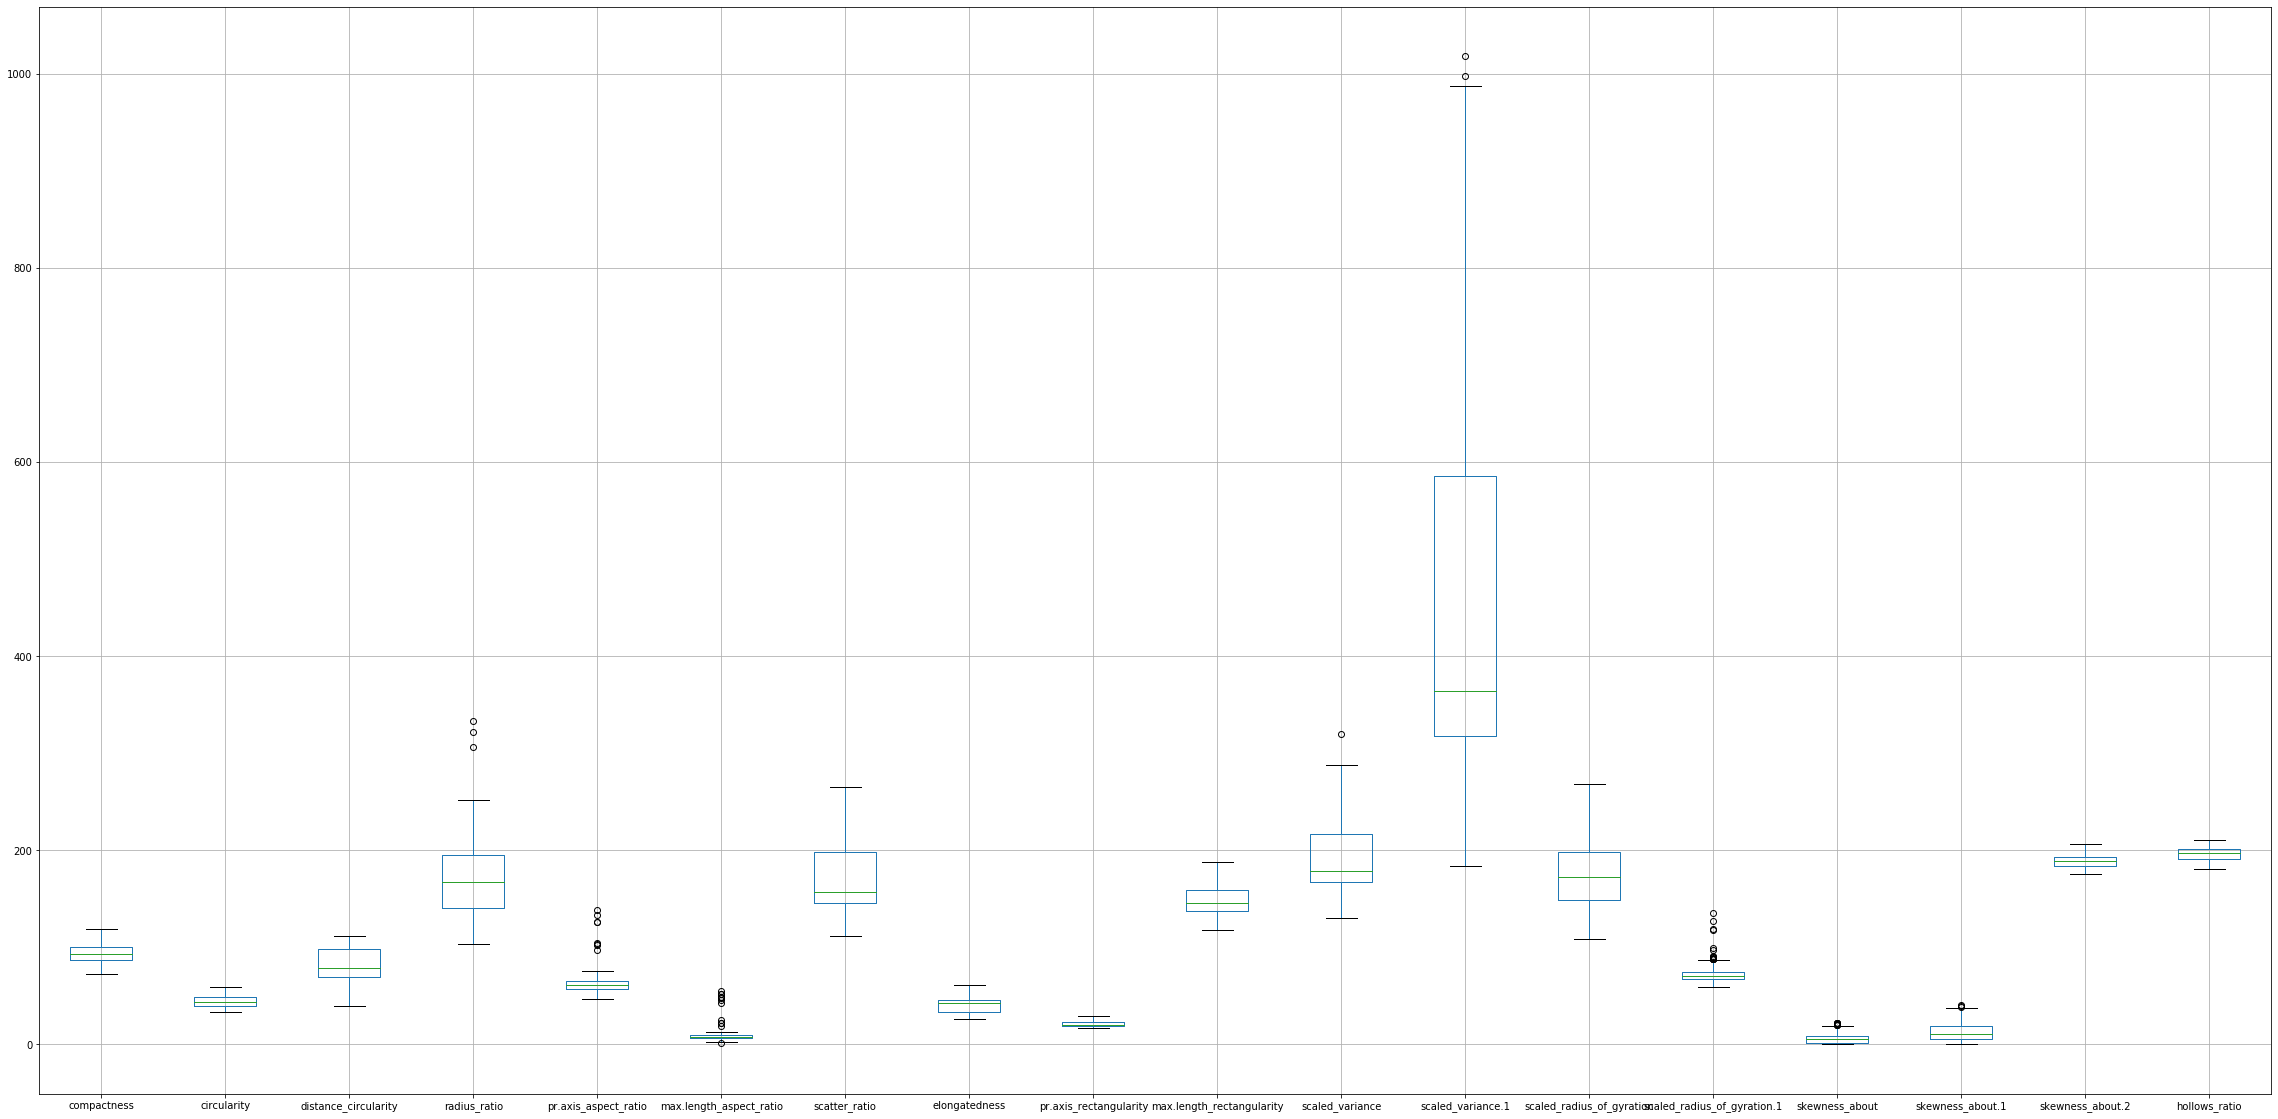

In [9]:
vehicleX.boxplot(figsize = (40,20))

In [13]:
Q1 = vehicleX.quantile(0.25)
Q3 = vehicleX.quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

In [15]:
#Imputing outliers
outliers =((vehicleX<lower_limit)|(vehicleX>upper_limit)).sum()
for i in range(len(vehicleX.columns)):
    if outliers[vehicleX.columns[i]] != 0:
        vehicleX[vehicleX.columns[i]] = np.where(vehicleX[vehicleX.columns[i]] > upper_limit[vehicleX.columns[i]],int(upper_limit[vehicleX.columns[i]]),vehicleX[vehicleX.columns[i]])
        vehicleX[vehicleX.columns[i]] = np.where(vehicleX[vehicleX.columns[i]] < lower_limit[vehicleX.columns[i]],int(lower_limit[vehicleX.columns[i]] + 1),vehicleX[vehicleX.columns[i]])

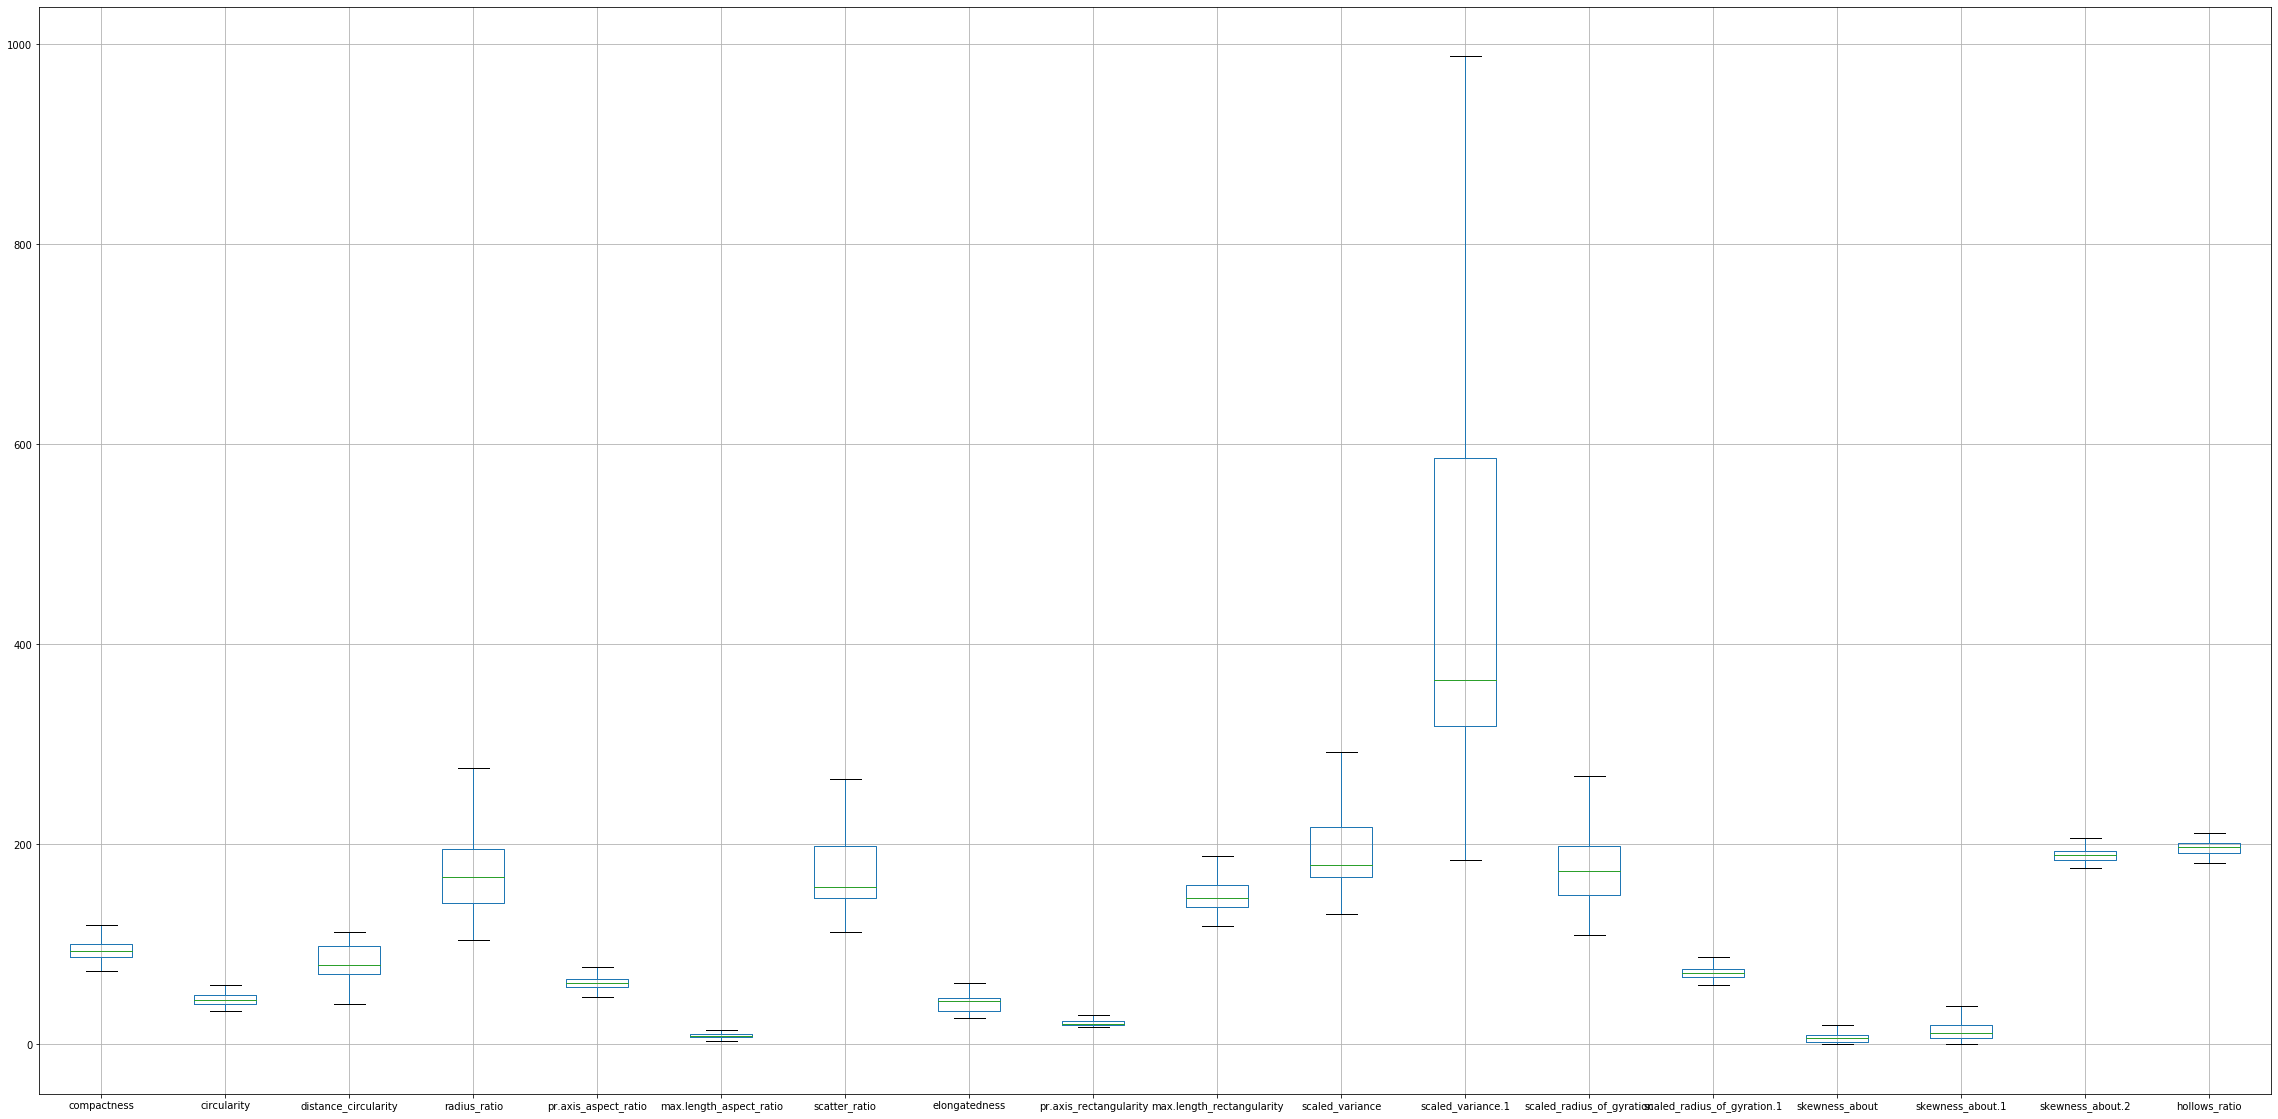

In [16]:
vehicleX.boxplot(figsize = (40,20))

#### Finding correlation between different features and plotting correlation heatmap for better visualization

In [20]:
corr = vehicleX.corr()

In [21]:
columns1 = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns1[j]:
                columns1[j] = False
                
selected_features1 = vehicleX.columns[columns1]
removed_features1 = vehicleX.columns[columns1 == False]
vehicleX1 = vehicleX[selected_features1]
vehicleX1.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,elongatedness,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,95,48.0,83.0,178.0,72.0,10,42.0,70.0,6.0,16.0,187.0,197
1,91,41.0,84.0,141.0,57.0,9,45.0,72.0,9.0,14.0,189.0,199
2,104,50.0,106.0,209.0,66.0,10,32.0,73.0,14.0,9.0,188.0,196
3,93,41.0,82.0,159.0,63.0,9,46.0,63.0,6.0,10.0,199.0,207
4,85,44.0,70.0,205.0,77.0,14,45.0,87.0,9.0,11.0,180.0,183


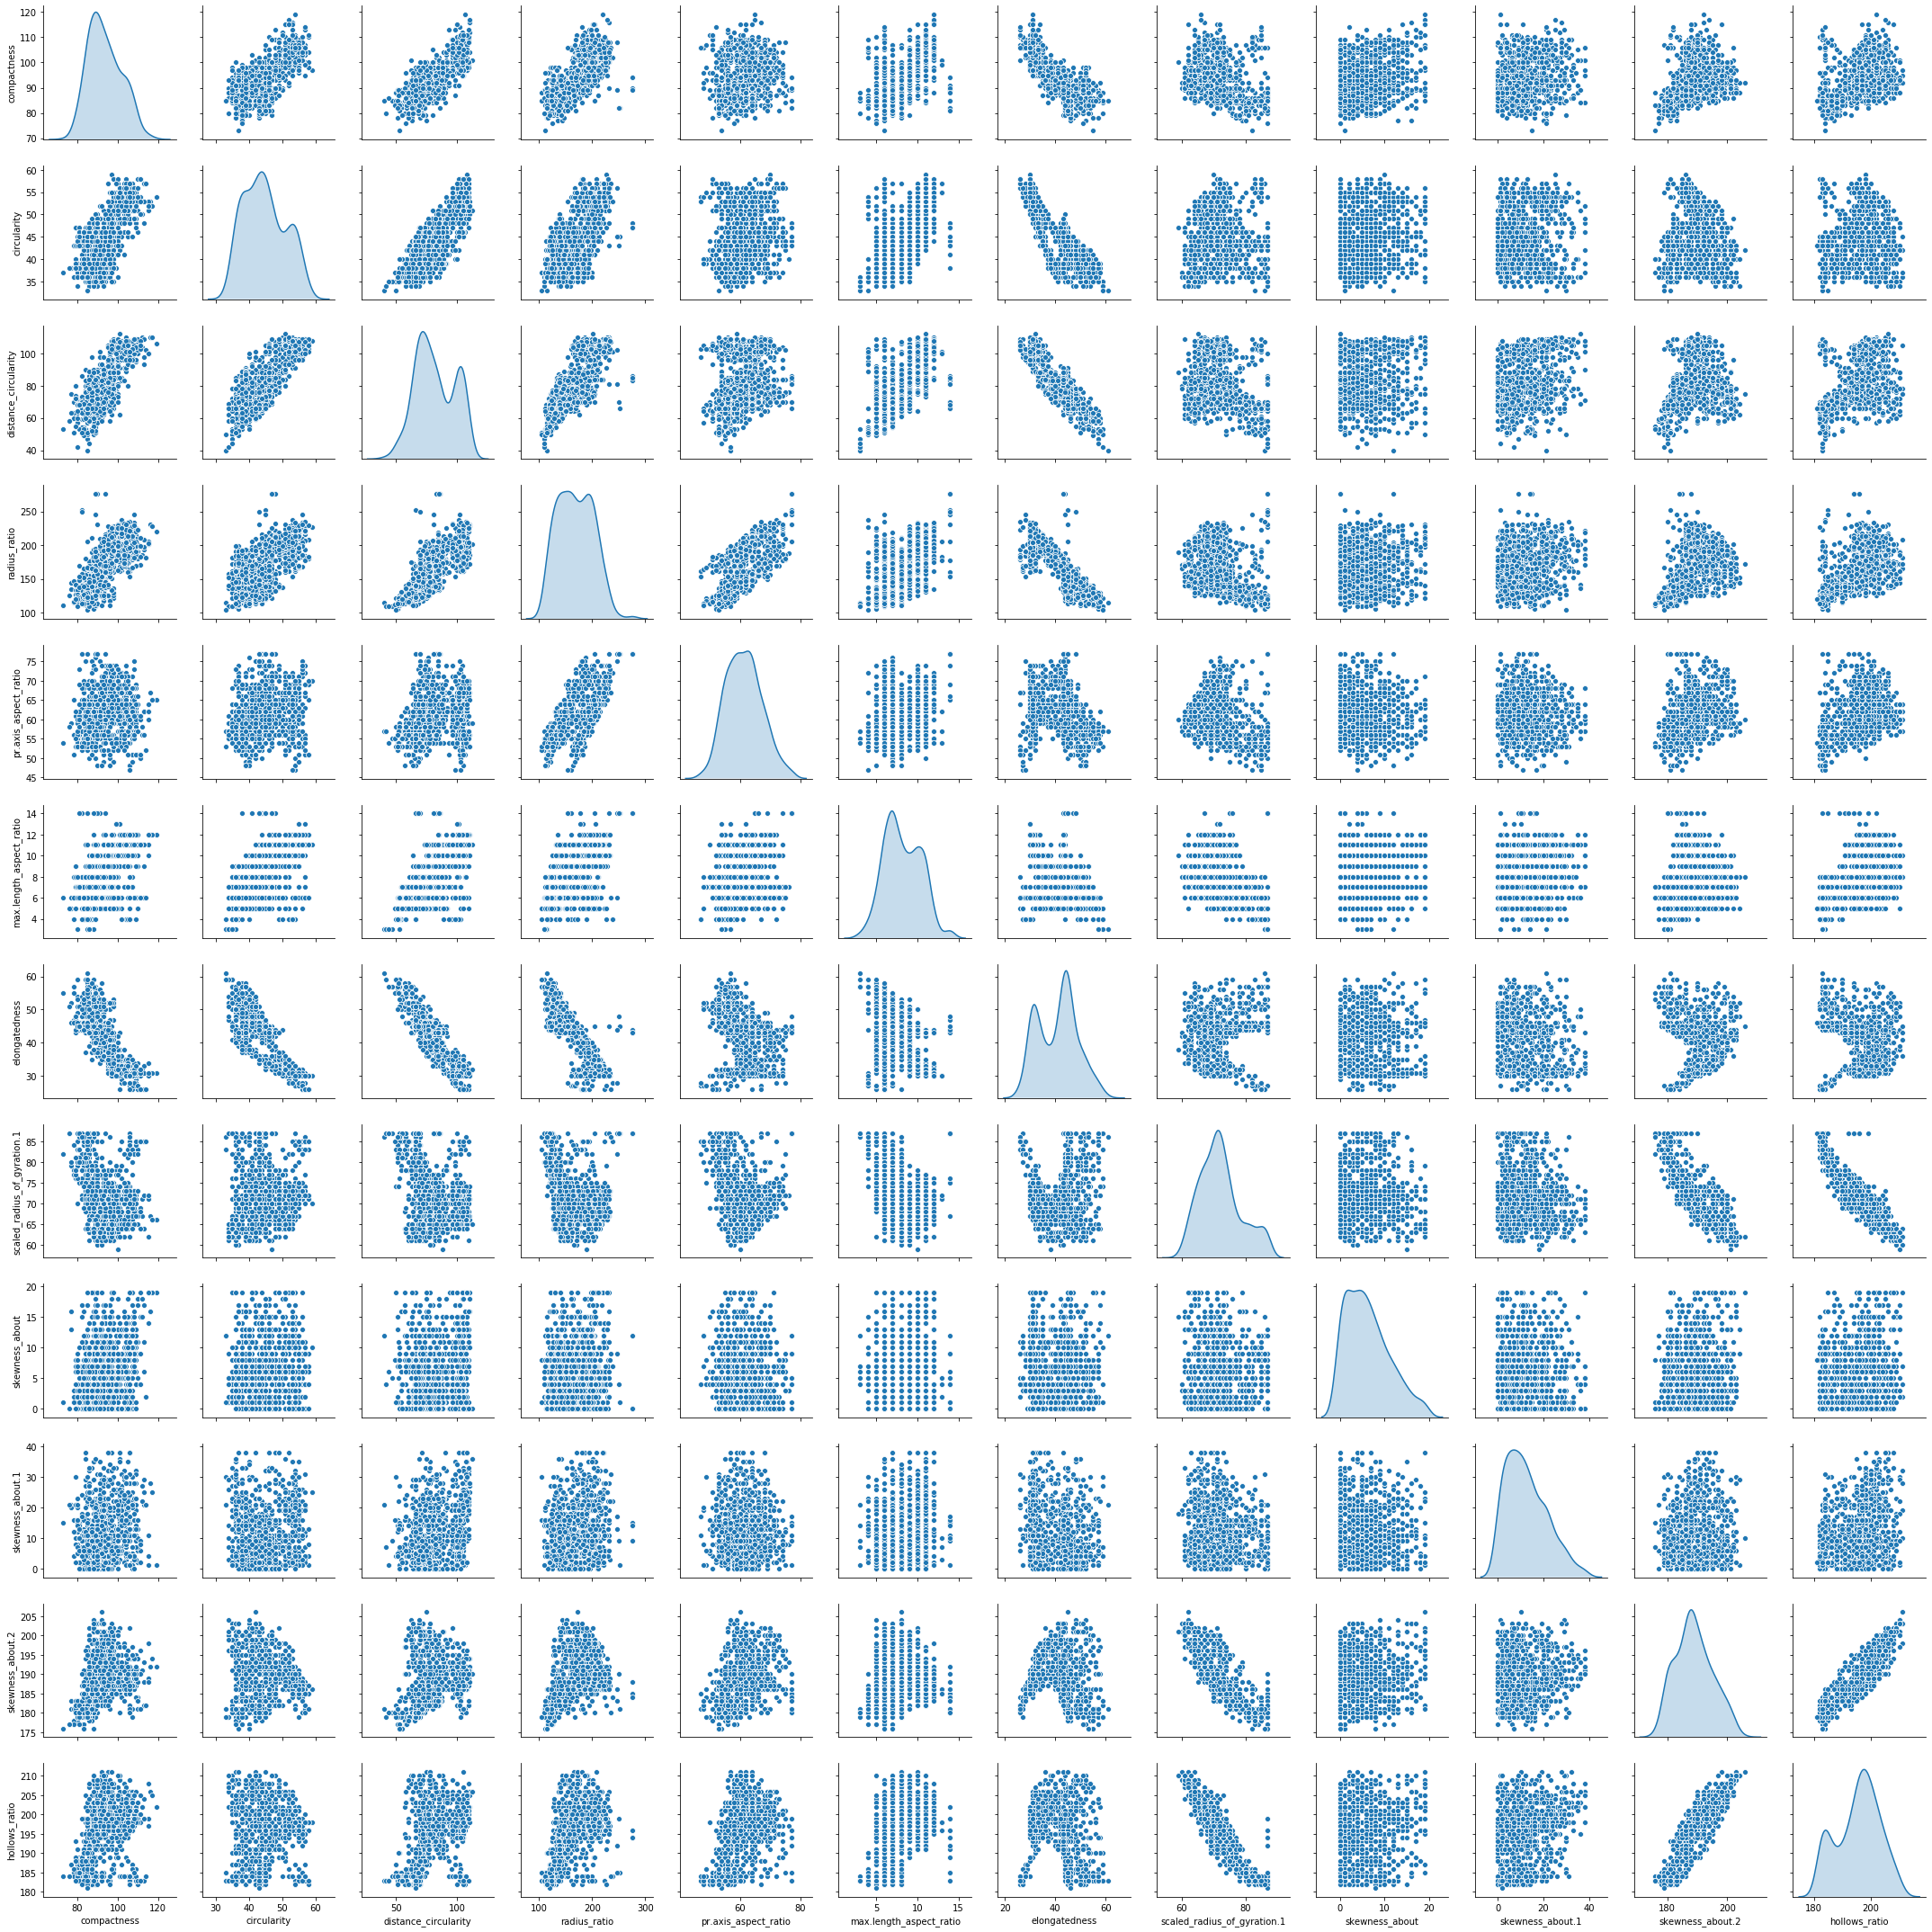

In [22]:
sns.pairplot(vehicleX1, diag_kind = 'kde')

In [23]:
#Standardizing
vehicleXscaled = vehicleX1.apply(zscore)

In [24]:
# Create covariance matrix
cov_matrix = np.cov(vehicleXscaled.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00123153  0.69073497  0.79092746  0.70377796  0.16788275  0.45629273
  -0.78902127 -0.2752691   0.22854869  0.16858594  0.29656022  0.3732647 ]
 [ 0.69073497  1.00123153  0.79868656  0.63492543  0.20053277  0.53490255
  -0.8261242   0.05333274  0.1421863  -0.00153564 -0.1140426   0.04939203]
 [ 0.79092746  0.79868656  1.00123153  0.78661123  0.2370389   0.62774698
  -0.9138366  -0.26354646  0.10943936  0.27835453  0.14543699  0.34365085]
 [ 0.70377796  0.63492543  0.78661123  1.00123153  0.68697896  0.50110224
  -0.81368373 -0.32850547  0.04451156  0.1822188   0.3858339   0.48124398]
 [ 0.16788275  0.20053277  0.2370389   0.68697896  1.00123153  0.22235369
  -0.28885565 -0.23190925 -0.05844364 -0.03834145  0.35927526  0.38045507]
 [ 0.45629273  0.53490255  0.62774698  0.50110224  0.22235369  1.00123153
  -0.47523115 -0.26202191  0.0897001   0.13016131  0.05328467  0.37568904]
 [-0.78902127 -0.8261242  -0.9138366  -0.81368373 -0.28885565 -0.47523115
   1.00123

In [25]:
#Get eigen values and eigen vector
e_vals, e_vecs = np.linalg.eig(cov_matrix)
print('Eigenvectors \n%s' %e_vecs)
print('\nEigenvalues \n%s' %e_vals)

Eigenvectors 
[[ 3.65401222e-01 -1.25497320e-01 -1.99623843e-01  7.41417390e-02
   3.40161905e-01 -9.37072236e-03 -7.43073734e-01  7.28629287e-02
   3.40170200e-01  3.04630332e-02  1.07047349e-01 -6.33820544e-02]
 [ 3.13246550e-01 -3.66226360e-01  3.98725492e-03  1.52077656e-01
   7.03705385e-02  1.08763630e-01  3.48093258e-01  7.50822382e-01
   9.75534069e-02 -6.61073406e-02 -1.56229396e-01  6.80599928e-02]
 [ 3.93216412e-01 -2.01361605e-01 -9.76431127e-02 -1.01180664e-01
   5.80939585e-02  7.80609551e-02  2.84731366e-01 -3.83308290e-01
   1.02713676e-01 -2.30293422e-01  4.31544453e-01  5.45693377e-01]
 [ 3.98590565e-01 -3.56946087e-02  2.74503592e-01  3.71848439e-03
  -7.82547811e-04 -2.36040653e-01 -6.16730079e-02 -2.61814528e-01
  -1.09799284e-01  2.19013814e-01 -6.98644771e-01  2.97139275e-01]
 [ 2.11931502e-01  1.36115062e-01  6.39022376e-01  1.36392642e-01
  -3.20309463e-01 -4.27024604e-01 -3.60515551e-02  9.61938468e-02
   2.53477897e-01 -1.16177627e-01  3.39092819e-01 -1.46191

Cumulative Variance Explained [ 43.20786652  64.40086072  74.16459467  83.04753179  89.29134878
  94.90177627  96.75588856  97.99263486  98.90738903  99.33200695
  99.72456828 100.        ]


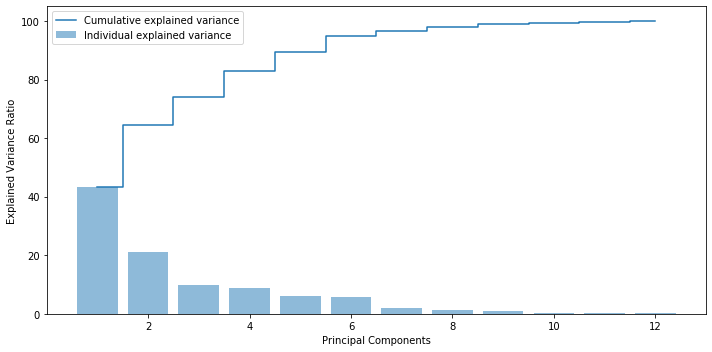

In [26]:
tot = sum(e_vals)
var_exp = [( i /tot ) * 100 for i in sorted(e_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)
# Ploting 
plt.figure(figsize=(10 , 5))
plt.bar(range(1, e_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, e_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

#### first 7 components covers more than 95% of variance

In [27]:
pca = PCA(n_components=7)
vehicleXreduced = pca.fit_transform(vehicleXscaled)
vehicleXreduced.transpose()

array([[-1.01660725,  0.66643442, -2.65096926, ..., -3.4129435 ,
         1.60198743,  3.51894352],
       [-0.05078987, -0.49038838,  1.20876655, ...,  1.13948389,
        -1.51884587, -0.73168872],
       [ 1.00207102, -1.10302776, -0.33883662, ...,  1.19487009,
        -0.18412601, -0.22276083],
       ...,
       [ 0.39682712, -0.39947615,  0.67479969, ..., -1.17955982,
        -0.24239935, -0.09280282],
       [ 1.23795267,  0.50552731,  0.36797871, ...,  0.20853249,
        -0.02104125, -0.47887497],
       [ 0.10026079, -0.00994505,  0.12442344, ...,  0.41621047,
        -0.23344235,  0.07711931]])

In [28]:
X = vehicleXreduced
y = vehicle['class']

In [29]:
C = [0.01,0.05,0.5,1]
kernel = ['linear', 'rbf']
svc = svm.SVC(gamma='scale')

In [30]:
kfold = KFold(n_splits=10, random_state=7)

In [31]:
param_grid = dict(C=C,kernel=kernel)
grid = GridSearchCV(estimator=svc, param_grid=param_grid, cv = kfold, n_jobs=-1)
grid_result = grid.fit(X, y)
best_hyperparams = grid_result.best_params_

C:\Users\rtaralekar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [32]:
result = cross_val_score(grid_result.estimator, X, y, cv = kfold, scoring='accuracy')
print(result.mean())

0.9088828666064439
